In [1]:
import os
import glob
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray

In [2]:
def rectangle_clip(gdf, xrds):
    # Find the bounding box of the shapefile
    bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]
    xrds.rio.set_spatial_dims('lon', 'lat')
    xrds.rio.write_crs("EPSG:4326", inplace=True)
    return xrds.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])

In [3]:
gdf = gpd.read_file("SHP/chn_adm_ocha_2020_shp", layer=2)

JS = gdf[gdf['ADM1_PCODE'] == 'CN032']
HB = gdf[gdf['ADM1_PCODE'] == 'CN042']
HN = gdf[gdf['ADM1_PCODE'] == 'CN043']
ZJ = gdf[gdf['ADM1_PCODE'] == 'CN033']
JX = gdf[gdf['ADM1_PCODE'] == 'CN036']
AH = gdf[gdf['ADM1_PCODE'] == 'CN034']
SH = gdf[gdf['ADM1_PCODE'] == 'CN031']

shpli = [JS, HB, HN, ZJ, JX, AH]

basin = gpd.read_file("SHP/major_basins_of_the_world_0_0_0.zip")

pcode_li=['CN032', 'CN033', 'CN034', 'CN036', 'CN042', 'CN043']

In [4]:
yrb=basin[basin['NAME']=='Yangtze']
multi=gpd.GeoDataFrame(pd.concat(shpli, ignore_index=True))

In [5]:
models=[f.name for f in os.scandir('formatted_grid') if f.is_dir() and f.name != 'cpc.observed']

# Sort models based on wave

In [6]:
def custom_sort(new_series_name, new_series, series_dict):
    """
    Sort a new time series into a dictionary of existing time series based on the sum of point-wise differences.
    
    Args:
    new_series_name (str): The name of the new time series.
    new_series (np.ndarray): The new time series to be inserted.
    existing_dict (dict): Dictionary of existing time series, with names as keys and time series as values.

    Returns:
    dict: A new dictionary with the new time series inserted in the correct position.
    """
    if new_series is None:
        return series_dict
    
    # Function to calculate the sum of point-wise differences
    def sum_of_differences(series1, series2):
        return np.sum(series1 - series2)

    # Convert to list of tuples for ordering
    items = list(series_dict.items())
    inserted = False

    for i, (name, series) in enumerate(items):
        diff = sum_of_differences(new_series, series)
        if diff < 0:
            items.insert(i, (new_series_name, new_series))
            inserted = True
            break

    if not inserted:
        items.append((new_series_name, new_series))

    # Convert back to dictionary
    return dict(items)

In [7]:
def compwave(mode, ssp, model):
    def is_ssp_available(exp):
        return exp in [path.split('.')[-3] for path in glob.glob(f'formatted_grid/{model}/*.nc')]
    if is_ssp_available(ssp):
        
        if mode == 'c':
            var='cold'
        elif mode == 'h':
            var='heat'
        else:
            raise ValueError
            
        if len(xr.open_dataset(f"waves/{experiment}_{model}_heatwave.nc")['time']) == 86:
            print('Time shape match. Using default strategy.')

            ds=rectangle_clip(multi, xr.open_dataset(f"waves/{ssp}_{model}_{var}wave.nc")[f'{var}wave_frequency']).mean(['lat', 'lon']).to_numpy()
            
        else:
            print('Aggregated SSPs. Using alt strategy.')
    
            try:
                ex=[]
                multip=0

                for s in ['ssp126', 
                            'ssp245',
                            'ssp370',
                            'ssp585']:
                    if not is_ssp_available(s):
                        ex.append(s)
    
                for s in ['ssp126', 
                            'ssp245',
                            'ssp370',
                            'ssp585']:
                    if not (s in ex):
                        if ssp==s:
                            ds=rectangle_clip(multi, xr.open_dataset(f"waves/{ssp}_{model}_{var}wave.nc")[f'{var}wave_frequency'][86*multip:86*(multip+1),:,:]).mean(['lat', 'lon']).to_numpy()
                        multip+=1
                    
            except:
                raise ValueError('Bad ssp dealing.')

        return ds
        
    else:
        return None    

In [ ]:
cdf={}
hdf={}


for experiment in ['ssp126', 'ssp245','ssp370','ssp585']:

    c={models[0]: compwave('c',experiment, models[0])}
    h={models[0]: compwave('h',experiment, models[0])}
    
    for model in models[1:]:
        print(model)
        c=custom_sort(model, compwave('c',experiment, model), c)
        h=custom_sort(model, compwave('h',experiment, model), h)
    
    hdf[experiment]=list(h.keys())
    cdf[experiment]=list(c.keys())

In [ ]:
def eq(cdf):
    # Find the maximum length of any list in the dictionary
    max_length = max(len(lst) for lst in cdf.values())

    # Equalize the length of all lists
    for key in cdf:
        length_difference = max_length - len(cdf[key])
        cdf[key].extend([None] * length_difference)

    return cdf

pd.DataFrame(eq(cdf)).to_csv('coldwave_order.csv')
pd.DataFrame(eq(hdf)).to_csv('heatwave_order.csv')

In [ ]:
df=pd.DataFrame()

for experiment in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    cdf=pd.DataFrame()
    hdf=pd.DataFrame()
    for prov in pcode_li:

        c, h=sortprov(models, prov, experiment)
        cdf[prov]=list(c.keys())
        hdf[prov]=list(h.keys())
        
    cdf.to_csv(f'{experiment}_order.csv')
    hdf.to_csv(f'{experiment}_order.csv')

In [ ]:
model=''

for i in range(2015, 2100):
    print(i)
    try:
        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/{model}/tas_day_{model}_historical_*_{i}.nc').variables['tasmax'][:]
    except:
        print('tasmax problem.')
        pass
    try:
        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/{model}/tas_day_{model}_historical_*_{i}.nc').variables['tasmin'][:]
    except:
        print('tasmin problem.')
        pass

# Heatwave time, coldwave time, heatwave coldwave

Graph heatwave anomaly to time (mean of 25 models space mean)
Graph coldwave anomaly to time (mean of 25 models space mean)

In [12]:
sspdict={}
sspdict['Years']=np.arange(2016,2101)
for experiment in ['ssp126', 'ssp245','ssp370','ssp585']:
    test={models[0]: (compwave('c',experiment, models[0]), compwave('h',experiment, models[0]))}
    for model in models[1:]:
        if not np.isnan(X0.loc[X0['Model'] == model][experiment].values[0]):
            print(model)
            test[model]=(compwave('c',experiment, model), compwave('h',experiment, model))
    
    sspdict[experiment]=test

Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
CNRM-CM6-1
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
BCC-CSM2-MR
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
ACCESS-CM2
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
CanESM5
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
MIROC-ES2L
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
CNRM-ESM2-1
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
EC-Earth3
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
KIOST-ESM
Time shape match. Using default strategy.
Time shape match. Using default strategy.
MIROC6
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
KACE-1-0-G
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
FGOALS-g3
Time shape match. Using default strategy.
Time shape match. Usi

In [ ]:
sspdict

In [13]:
import pandas as pd

# Assuming your current data structure is something like this:
# data = {'Years': np.ndarray, 'ssp126': subdict1, 'ssp245': subdict2, 'ssp370': subdict3, 'ssp585': subdict5}

# Transform the data into a list of dictionaries
data_list = []
for scenario, subdict in sspdict.items():
    if scenario != 'Years':
        for model, (coldwave, heatwave) in subdict.items():
            for year, hw, cw in zip(sspdict['Years'], heatwave, coldwave):
                data_list.append({'Year': year, 'Scenario': scenario, 'Model': model, 'Heatwave': hw, 'Coldwave': cw})

# Create a DataFrame from the list
df = pd.DataFrame(data_list)

In [17]:
df

Year Scenario          Model   Heatwave  Coldwave
0     2016   ssp126  ACCESS-ESM1-5   6.195670  7.966720
1     2017   ssp126  ACCESS-ESM1-5   5.777065  6.408180
2     2018   ssp126  ACCESS-ESM1-5   6.949078  9.561347
3     2019   ssp126  ACCESS-ESM1-5   8.403769  6.925822
4     2020   ssp126  ACCESS-ESM1-5   7.866480  6.286688
...    ...      ...            ...        ...       ...
7050  2096   ssp585     NorESM2-LM  10.500401  1.334002
7051  2097   ssp585     NorESM2-LM  12.515237  1.820770
7052  2098   ssp585     NorESM2-LM  10.748196  2.580192
7053  2099   ssp585     NorESM2-LM  11.987971  1.057739
7054  2100   ssp585     NorESM2-LM  10.468324  2.732959

[7055 rows x 5 columns]

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with the columns ['Year', 'Scenario', 'Model', 'Heatwave', 'Coldwave']

# Group by 4-year intervals
# This assumes 'Year' is in a format that can be divided (e.g., 2000, 2001, ...)
ndf=df.loc[df['Year']>2016].copy()
ndf['Year Group'] = (ndf['Year'] - 1) // 4
ndf['Year Group'] = ndf['Year Group'] * 4 + 1 - 2000

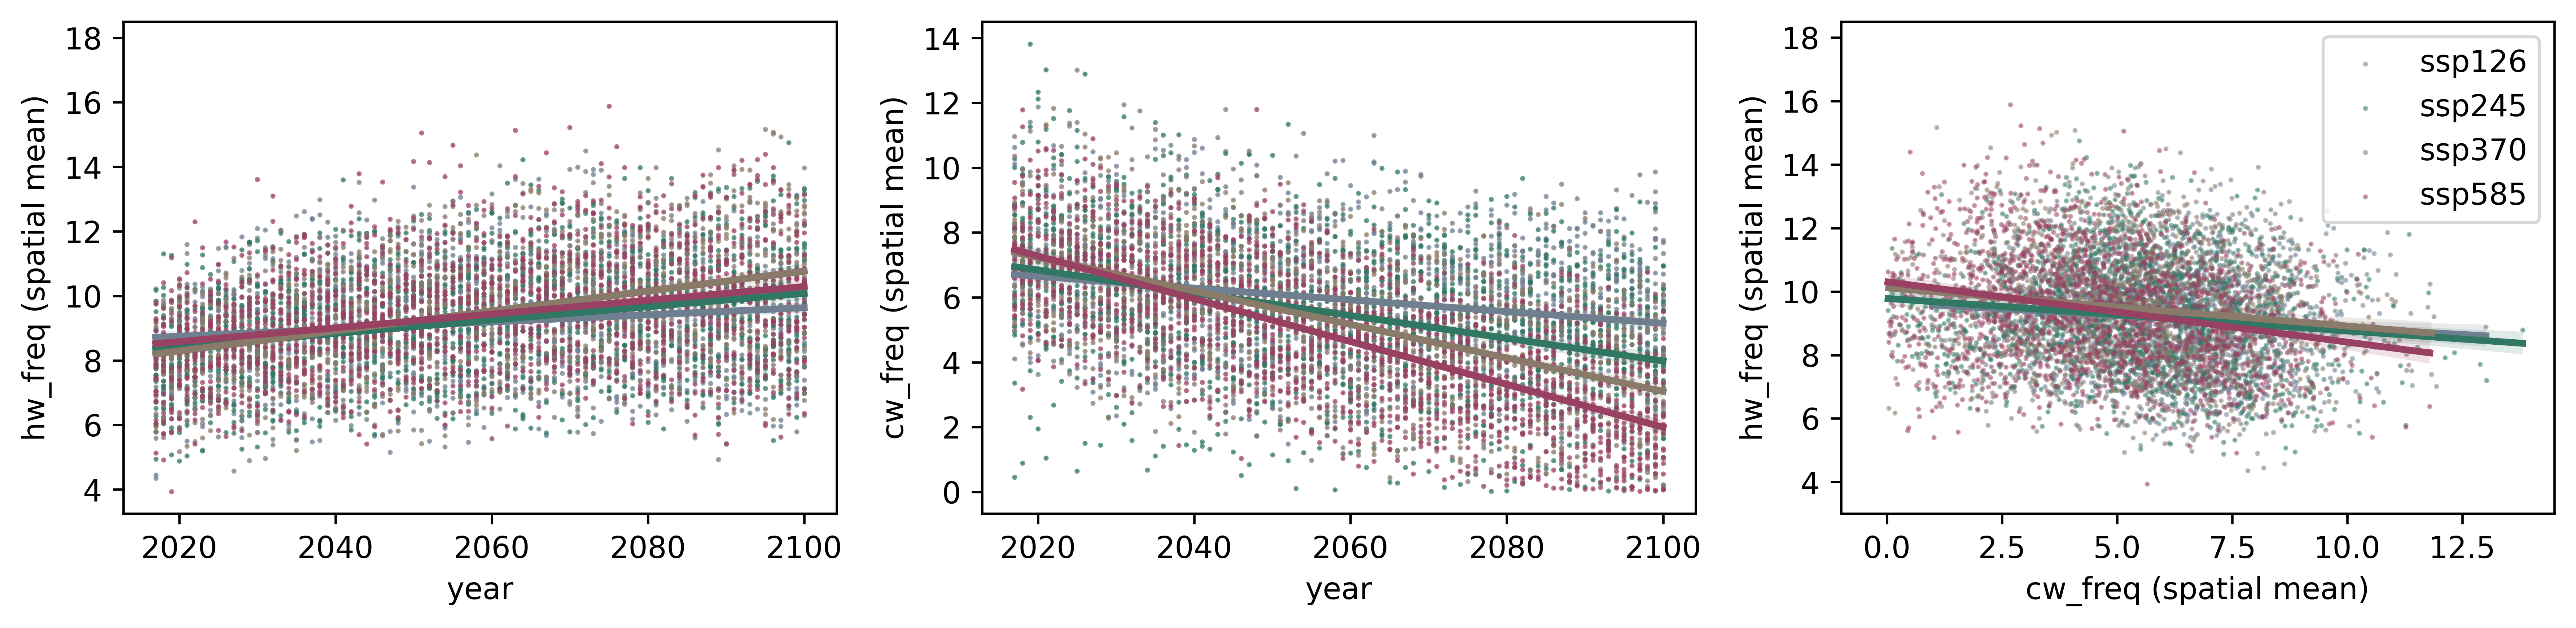

In [70]:
# Create a 2x2 grid of subplots with merged right column
fig, axes = plt.subplots(1, 3, figsize=(12,3), dpi=600)
#big_ax = fig.add_subplot(1, 2, 2)  # Create a big subplot on the right for the third plot

#sns.boxplot(x='Year Group', y='Heatwave', data=ndf, hue='Scenario', whis=[0, 100], width=0.85,  ax=axes[0], gap=0.2, palette=cli, linewidth=0.5)
#sns.boxplot(x='Year Group', y='Coldwave', data=ndf, hue='Scenario', whis=[0, 100], width=0.85,  ax=axes[1], gap=0.2, palette=cli, linewidth=0.5)

for i in range(4):
    sns.regplot(data=ndf[ndf['Scenario']==ssps[i]], x='Year', y='Heatwave', color=cli[i], scatter_kws={"alpha": 0.7, "s": 0.5}, ci=99, ax=axes[0], label=ssps[i])
    sns.regplot(data=ndf[ndf['Scenario']==ssps[i]], x='Year', y='Coldwave', color=cli[i], scatter_kws={"alpha": 0.7, "s": 0.5}, ci=99, ax=axes[1], label=ssps[i])
    sns.regplot(data=ndf[ndf['Scenario']==ssps[i]], x='Coldwave', y='Heatwave', color=cli[i], scatter_kws={"alpha": 0.5, "s": 0.5}, ci=99, ax=axes[2], label=ssps[i])

# Adding labels and titles
axes[0].set_xlabel('year')
axes[0].set_ylabel('hw_freq (spatial mean)')
axes[1].set_xlabel('year')
axes[1].set_ylabel('cw_freq (spatial mean)')
axes[2].set_xlabel('cw_freq (spatial mean)')
axes[2].set_ylabel('hw_freq (spatial mean)')

axes[0].set_ylim([3.25, 18.5])
axes[2].set_ylim([3, 18.5])
axes[2].set_xlim([-1, 14.5])

# Add legends
#axes[0].legend(loc='upper right')
#axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')

fig.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

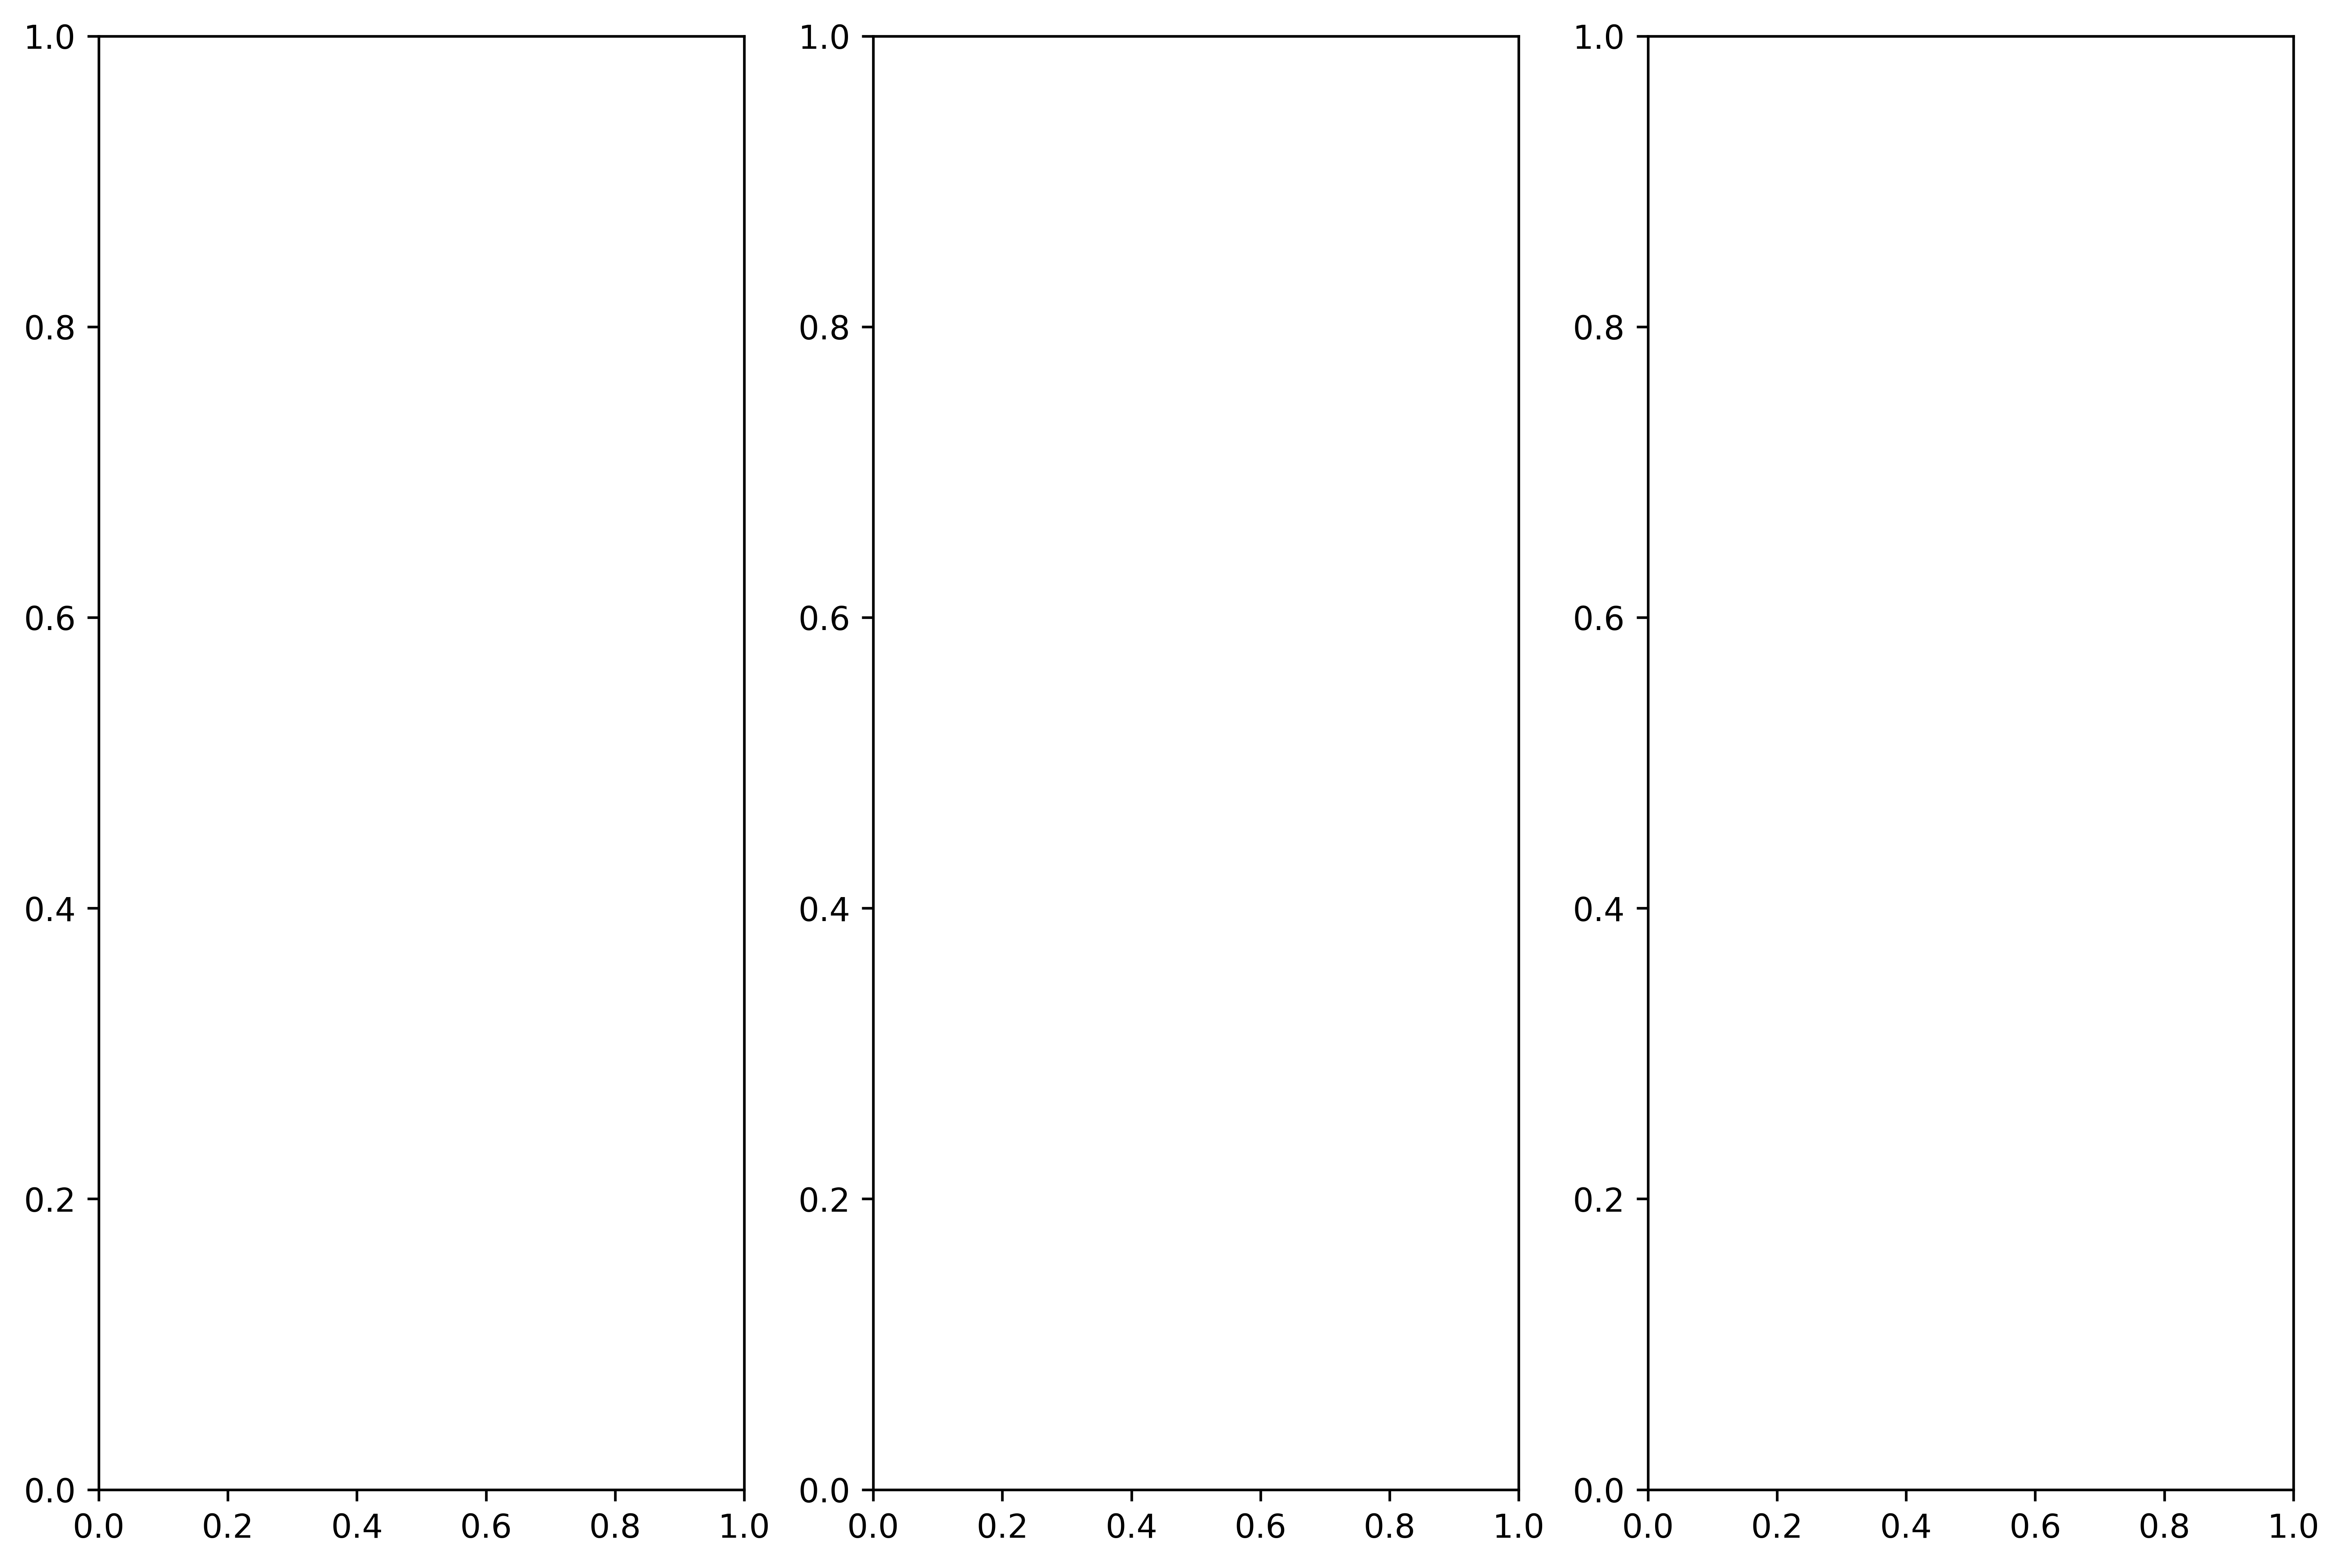

In [20]:
# Create a 2x2 grid of subplots with merged right column
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=600, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
big_ax = fig.add_subplot(1, 2, 2)  # Create a big subplot on the right for the third plot
# Remove the original subplots on the second column
axes[0, 1].remove()
axes[1, 1].remove()
# Plotting
sns.boxplot(x='Year Group', y='Heatwave', data=ndf, hue='Scenario', whis=[0, 100], width=0.85,  ax=axes[0, 0], gap=0.2, palette=cli, linewidth=0.5)
sns.boxplot(x='Year Group', y='Coldwave', data=ndf, hue='Scenario', whis=[0, 100], width=0.85,  ax=axes[1, 0], gap=0.2, palette=cli, linewidth=0.5)

for i in range(4):
    sns.regplot(data=ndf[ndf['Scenario']==ssps[i]], x='Coldwave', y='Heatwave', color=cli[i], scatter_kws={"alpha": 0.5, "s": 5}, ci=99, ax=big_ax, label=ssps[i])

# Adding labels and titles
axes[0, 0].set_xlabel('temporal distance from 2000 (year)')
axes[0, 0].set_ylabel('hw_freq (spatial mean)')
axes[1, 0].set_xlabel('temporal distance from 2000 (year)')
axes[1, 0].set_ylabel('cw_freq (spatial mean)')
big_ax.set_xlabel('cw_freq (spatial mean)')
big_ax.set_ylabel('hw_freq (spatial mean)')

axes[0, 0].set_ylim([3.25, 18.5])
big_ax.set_ylim([3.25, 18.5])

# Add legends
axes[0, 0].legend(loc='upper right')
axes[1, 0].legend(loc='upper right')
big_ax.legend(loc='upper right')

fig.tight_layout()
plt.show()

In [ ]:
# Set up the plot
fig, axes = plt.subplots(3, 1, figsize=(8, 13), dpi=500)

ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
cli = ['#6f7f90', '#307764', '#8a7a6a', '#994162']



sns.boxplot(x='Year Group', y='Heatwave', data=ndf, hue='Scenario', whis=[0, 100], width=0.85,  ax=axes[0], gap=0.2, palette=cli,linewidth=0.5)
sns.boxplot(x='Year Group', y='Coldwave', data=ndf, hue='Scenario',whis=[0, 100], width=0.85,  ax=axes[1], gap=0.2, palette=cli, linewidth=0.5)

for i in range(4):
    sns.regplot(data=ndf[ndf['Scenario']==ssps[i]], x='Coldwave', y='Heatwave', color=cli[i], scatter_kws = {"alpha": 0.5, "s": 5},ci=99,  ax=axes[2], label=ssps[i]) #

# Adding labels and titles
axes[0].set_xlabel('Group Starting Distance from 2000 [year]')
axes[0].set_ylabel('hw_freq (spatial mean)')
axes[1].set_xlabel('Group Starting Distance from 2000 [year]')
axes[1].set_ylabel('cw_freq (spatial mean)')
axes[2].set_xlabel('cw_freq (spatial mean)')
axes[2].set_ylabel('hw_freq (spatial mean)')

axes[0].set_ylim([3.25, 18.5])
axes[2].set_ylim([3.25, 18.5])

# Add legends
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')

fig.tight_layout()
plt.show()

In [ ]:
axes[0].set_yscale('logit')
axes[1].set_yscale('logit')
axes[2].set_yscale('logit')

In [ ]:
fig

# Make model data descriptives

% increase in mean descriptives from baseline (1981\~2010) are calculated for 2021\~2040 2041\~2060 2061\~2080 2081\~2100

This is calculated for each point and then mean together

In [6]:
import warnings
    
def resample(ds, tvarname, datavarname, new_x=50, new_y=50, to_numpy=True, autoclip=True, s_e=None):
    warnings.simplefilter("ignore")

    if autoclip:
        data=rectangle_clip(multi, ds)

    else:
        data=ds
    
    new_data = data.interp(
        lon=np.linspace(data.lon.min(), data.lon.max(), new_x),
        lat=np.linspace(data.lat.min(), data.lat.max(), new_y)
    )

    lat_dim = new_y
    lon_dim = new_x

    result_array = np.empty((0, lat_dim, lon_dim))

    if s_e is None:
        if to_numpy:
            return new_data[varname].to_numpy()
        else:
            return new_data[varname]

    else:

        for i in new_data[datavarname]:

            if int(i[tvarname])<=s_e[1] and int(i[tvarname]) >= s_e[0]:
                result_array=np.concatenate((result_array, i.values[np.newaxis, :, :]), axis=0)

    return result_array

In [7]:
def group_resample(ds, tvarname, datavarname, new_x=52, new_y=52, to_numpy=True, autoclip=True, s_e=None, method='sum'):
    warnings.simplefilter("ignore")

    if autoclip:
        data=rectangle_clip(multi, ds)
    else:
        data=ds
    
    new_data = data.interp(
        lon=np.linspace(data.lon.min(), data.lon.max(), new_x),
        lat=np.linspace(data.lat.min(), data.lat.max(), new_y)
    )
    
    # Assuming ds is your xarray dataset
    # Group by year
    grouped = new_data[datavarname].groupby(f'{tvarname}.year')

    # Pre-allocate a numpy array to store the results
    nyear = len(grouped.groups)
    lat_dim = new_y
    lon_dim = new_x

    result_array = np.empty((0, lat_dim, lon_dim))

    # Iterate through each group and fill the result_array
    for year, group in grouped:
        if s_e is None:
            run=True
        else: 
            if year<=s_e[1] and year >= s_e[0]:
                run=True
            else:
                run=False
        
        if run:
            
            # Aggregate monthly data for each year
            if method == 'mean':
                monthly_data = group.mean(tvarname)

            elif method == 'sum':
                monthly_data = group.sum(tvarname)  # or any other aggregation method

            else:
                raise ValueError
            
            result_array=np.concatenate((result_array, monthly_data.values[np.newaxis, :, :]), axis=0)
            
    return result_array

## Make baseline

In [8]:
r=[1981, 2010]

In [9]:
cbase=resample(xr.open_dataset("waves/observed_cpc_coldwave.nc"), 'time', 'coldwave_frequency', new_x=300, new_y=200, s_e=r)
hbase=resample(xr.open_dataset("waves/observed_cpc_heatwave.nc"), 'time', 'heatwave_frequency', new_x=300, new_y=200, s_e=r)

In [10]:
import matplotlib.pyplot as plt

In [11]:
cbase.shape

(30, 200, 300)

In [12]:
tasbase=group_resample(xr.open_dataset("Observed_data/tas/air.mon.mean.nc"), 'time', 'air',  new_x=300, new_y=200, s_e=r, method='mean')
prbase=group_resample(xr.open_mfdataset("Observed_data/precip/*.nc"), 'time', 'precip', new_x=300, new_y=200, s_e=r)

In [13]:
prbase.mean(0)

array([[1394.5377299 , 1396.16045532, 1397.78319906, ...,    0.        ,
           0.        ,    0.        ],
       [1385.92904663, 1388.55123494, 1391.17346598, ...,    0.        ,
           0.        ,    0.        ],
       [1377.32034505, 1380.94203288, 1384.56370646, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ 527.82454529,  532.13102519,  536.43749695, ...,    0.        ,
           0.        ,    0.        ],
       [ 526.20205994,  530.96211751,  535.72218526, ...,    0.        ,
           0.        ,    0.        ],
       [ 524.57956136,  529.79321187,  535.00687968, ...,    0.        ,
           0.        ,    0.        ]])

## Make future

In [14]:
import time
import concurrent.futures

def process_year(grouped, year, datavarname, tvarname):
    if datavarname == 'pr':
        yearly_data = grouped[year].sum(dim=tvarname) * 86400
    else:
        yearly_data = grouped[year].mean(dim=tvarname)
    
    return year, yearly_data

def makedata(model, experiment, datavarname, tvarname, new_x=300, new_y=200, s_e=None, p=True):
    start_time = time.time()
    
    # Open the dataset
    if datavarname == 'pr': 
        ds = xr.open_mfdataset(f'NASA-CMIP/CMIP6-SSP-PR/{model}/{datavarname}_day_{model}_{experiment}_*.nc')
    else:
        ds = xr.open_mfdataset(f'NASA-CMIP/CMIP6-SSP-Temp/{model}/{datavarname}_day_{model}_{experiment}_*.nc')

    # Assuming rectangle_clip is a valid function that clips the data
    data = rectangle_clip(multi, ds[datavarname])
    if p:
        end_time = time.time()
        print(f'Read time: {end_time - start_time} s')
    
    # Interpolate data
        start_time = time.time()
        
    new_data = data.interp(lon=np.linspace(data.lon.min(), data.lon.max(), new_x), 
                           lat=np.linspace(data.lat.min(), data.lat.max(), new_y))
    
    if p:
        end_time = time.time()
        print(f'Interp time: {end_time - start_time} s')

        start_time = time.time()
    # Group by year
    grouped = new_data.groupby(f'{tvarname}.year')

    # Identify the years to process
    years = [year for year in grouped.groups if s_e is None or (year >= s_e[0] and year <= s_e[1])]

    # Multithreaded processing of each year
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # Submit all jobs
        futures = [executor.submit(process_year, grouped, year, datavarname, tvarname) for year in years]
        
        # Collect results as they complete
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    # Sort results by year
    results.sort(key=lambda x: x[0])

    # Concatenate sorted results
    lat_dim = len(new_data['lat'])
    lon_dim = len(new_data['lon'])
    result_array = np.empty((0, lat_dim, lon_dim))
    for _, yearly_data in results:
        result_array = np.concatenate((result_array, yearly_data.values[np.newaxis, :, :]), axis=0)

    end_time = time.time()
    print(f'Done {datavarname} {experiment} {model}: {end_time - start_time} s')
    
    return result_array

In [15]:
def process_model(exp, model, base_mean):
    
    print(f'Processing {var} {exp} {model}')
    
    if exp in [path.split('.')[-3] for path in glob.glob(f'formatted_grid/{model}/*.nc')]:
        m = makedata(model, exp, var, 'time', s_e=(2021, 2040), p=False)
        
        result = np.empty((0, 200, 300))
        
        for i in m:
            result = np.concatenate((result, (i - base_mean)[np.newaxis, :, :]), axis=0)

        return np.nanmean(result)

    else:
        return None

In [16]:
import time

start_time = time.time()
var='pr'
m=process_model('ssp245','ACCESS-CM2', tasbase.mean(0))
end_time = time.time()  # End timing
print(f'{end_time - start_time} s')

m

Processing pr ssp245 ACCESS-CM2
Done pr ssp245 ACCESS-CM2: 119.78444290161133 s
119.83972835540771 s


973.9017485127608

### From scratch to CSV

In [ ]:
models=[f.name for f in os.scandir('final_output') if f.is_dir()]

In [ ]:
try:
    models.remove('.ipynb_checkpoints')
except:
    print('no')

In [ ]:
collection={}

In [ ]:
start=time.time()

collection['Model'] = models
var = 'tas'
exps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

base_mean = tasbase.mean(0)

# Use ThreadPoolExecutor to process in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    future_to_exp_model = {}
    for exp in exps:
        for model in models:
            future = executor.submit(process_model, exp, model, base_mean)
            future_to_exp_model[future] = (exp, model)

    for future in future_to_exp_model:
        exp_model = future_to_exp_model[future]
        try:
            collection[exp_model] = future.result()
        except Exception as e:
            print(f"Error processing {exp_model}: {e}")

end=time.time()

print(f"TOTAL: {end-start}")

In [ ]:
collection[('ssp245', 'KACE-1-0-G')]=None
collection[('ssp245', 'GFDL-CM4')]=None
collection[('ssp245', 'NorESM2-LM')]=None

In [ ]:
df = pd.DataFrame(columns=['Model', 'ssp126', 'ssp245', 'ssp370', 'ssp585'])

# Fill the DataFrame
for key, value in collection.items():
    if key == 'Model':
        df['Model']=value
    else:
        exp, model = key
        df.loc[df['Model'] == model, exp] = value

In [ ]:
df.to_csv('final_output/tas_distance_2021_2040.csv')

In [ ]:
data=pd.DataFrame()
for model in models:

    result_df=pd.read_csv(f'final_output/{model}/results_{pcode_li[0]}.csv')
    result_df.drop('Unnamed: 0', axis=1)
    for prov in pcode_li[1:]:
        df2=pd.read_csv(f'final_output/{model}/results_{prov}.csv')
        df2.drop('Unnamed: 0', axis=1)
    
        for col in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
            try:
                result_df[col] = result_df[col] + df2[col]
            except KeyError as e:
                result_df[col] = None
                continue
                
    a=pd.DataFrame(result_df[(result_df['YEAR']<2041) & (result_df['YEAR']>2020)].drop('YEAR', axis=1).mean()).T
    a['Model']=model
    new_order = ['Model'] + [col for col in a.columns if col != 'Model' ]
    a = a[new_order]
    data=pd.concat([data, a], ignore_index=True)

In [ ]:
data.drop('Unnamed: 0', axis=1).to_csv('final_output/predmean_2021_2040.csv')

### From CSV

In [17]:
refyield=0
for pcode in pcode_li:
    econ=pd.read_csv(f"Observed_data/province/data.{pcode}.csv", na_values=['NONE'])
    print(econ.iloc[-21]['YEAR'], econ.iloc[-2]['YEAR'])
    
    refyield+=econ.iloc[-21:-1]['TGrainOut'].median()

2001.0 2020.0
2001.0 2020.0
2001.0 2020.0
2001.0 2020.0
2001.0 2020.0
2001.0 2020.0


In [18]:
refyield

14545.509999999998

In [19]:
X0=pd.read_csv('final_output/tas_distance_2021_2040.csv', usecols=range(1,6))
y0=pd.read_csv('final_output/predmean_2021_2040.csv', usecols=range(1,6))

X1=pd.read_csv('final_output/tas_distance_2041_2060.csv', usecols=range(1,6))
y1=pd.read_csv('final_output/predmean_2041_2060.csv', usecols=range(1,6))

X2=pd.read_csv('final_output/tas_distance_2081_2100.csv', usecols=range(1,6))
y2=pd.read_csv('final_output/predmean_2081_2100.csv', usecols=range(1,6))


for col in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    y0[col]=y0[col]-14545.509999999998
    y1[col]=y1[col]-14545.509999999998
    y2[col]=y2[col]-14545.509999999998

In [20]:
y0

Model      ssp126      ssp245      ssp370      ssp585
0     ACCESS-ESM1-5  108.590124  184.274947  115.845277   70.109489
1        CNRM-CM6-1    2.241871  -28.263754   12.896847   -6.458067
2       BCC-CSM2-MR -115.554108  -56.907143  -77.058530  -46.021168
3        ACCESS-CM2  -13.629255   20.822280   -0.931509   87.835115
4           CanESM5  124.601867  263.820334  193.658285  166.579105
5        MIROC-ES2L  191.121362  198.702947  246.114207  176.426839
6       CNRM-ESM2-1   24.754405   65.123859  112.318687   61.356952
7         EC-Earth3   12.689903   36.966610   45.075831   12.662126
8         KIOST-ESM   63.176794  106.138019         NaN   20.390106
9            MIROC6  -39.286777   65.234065  117.828925   12.645389
10       KACE-1-0-G    4.949425    0.998583   78.050937  -43.850159
11        FGOALS-g3   65.275125    5.040131   45.192086   17.032452
12      GISS-E2-1-G  256.971187   78.290528  164.632697   45.840938
13       MRI-ESM2-0   19.435922   51.078814    9.144479         NaN
14  HadGEM3-GC31-LL  -44.417808   34.108094         NaN   -8.985896
15        INM-CM4-8  162.078822  180.798784  242.027559  231.522155
16        INM-CM5-0   81.319220  114.113742   86.875929   97.992620
17     IPSL-CM6A-LR   34.877341  107.215158   86.343343   94.168503
18            NESM3  206.571844  157.450096         NaN  125.121565
19     CMCC-CM2-SR5         NaN  263.133584         NaN         NaN
20         GFDL-CM4         NaN  553.307428         NaN  494.397066
21        CMCC-ESM2  236.352742  219.706006  191.795478         NaN
22  HadGEM3-GC31-MM  -97.202314         NaN         NaN         NaN
23       NorESM2-LM  124.676693   84.394257   82.614651   60.710043
24      UKESM1-0-LL   70.964315   50.588589  104.716655         NaN

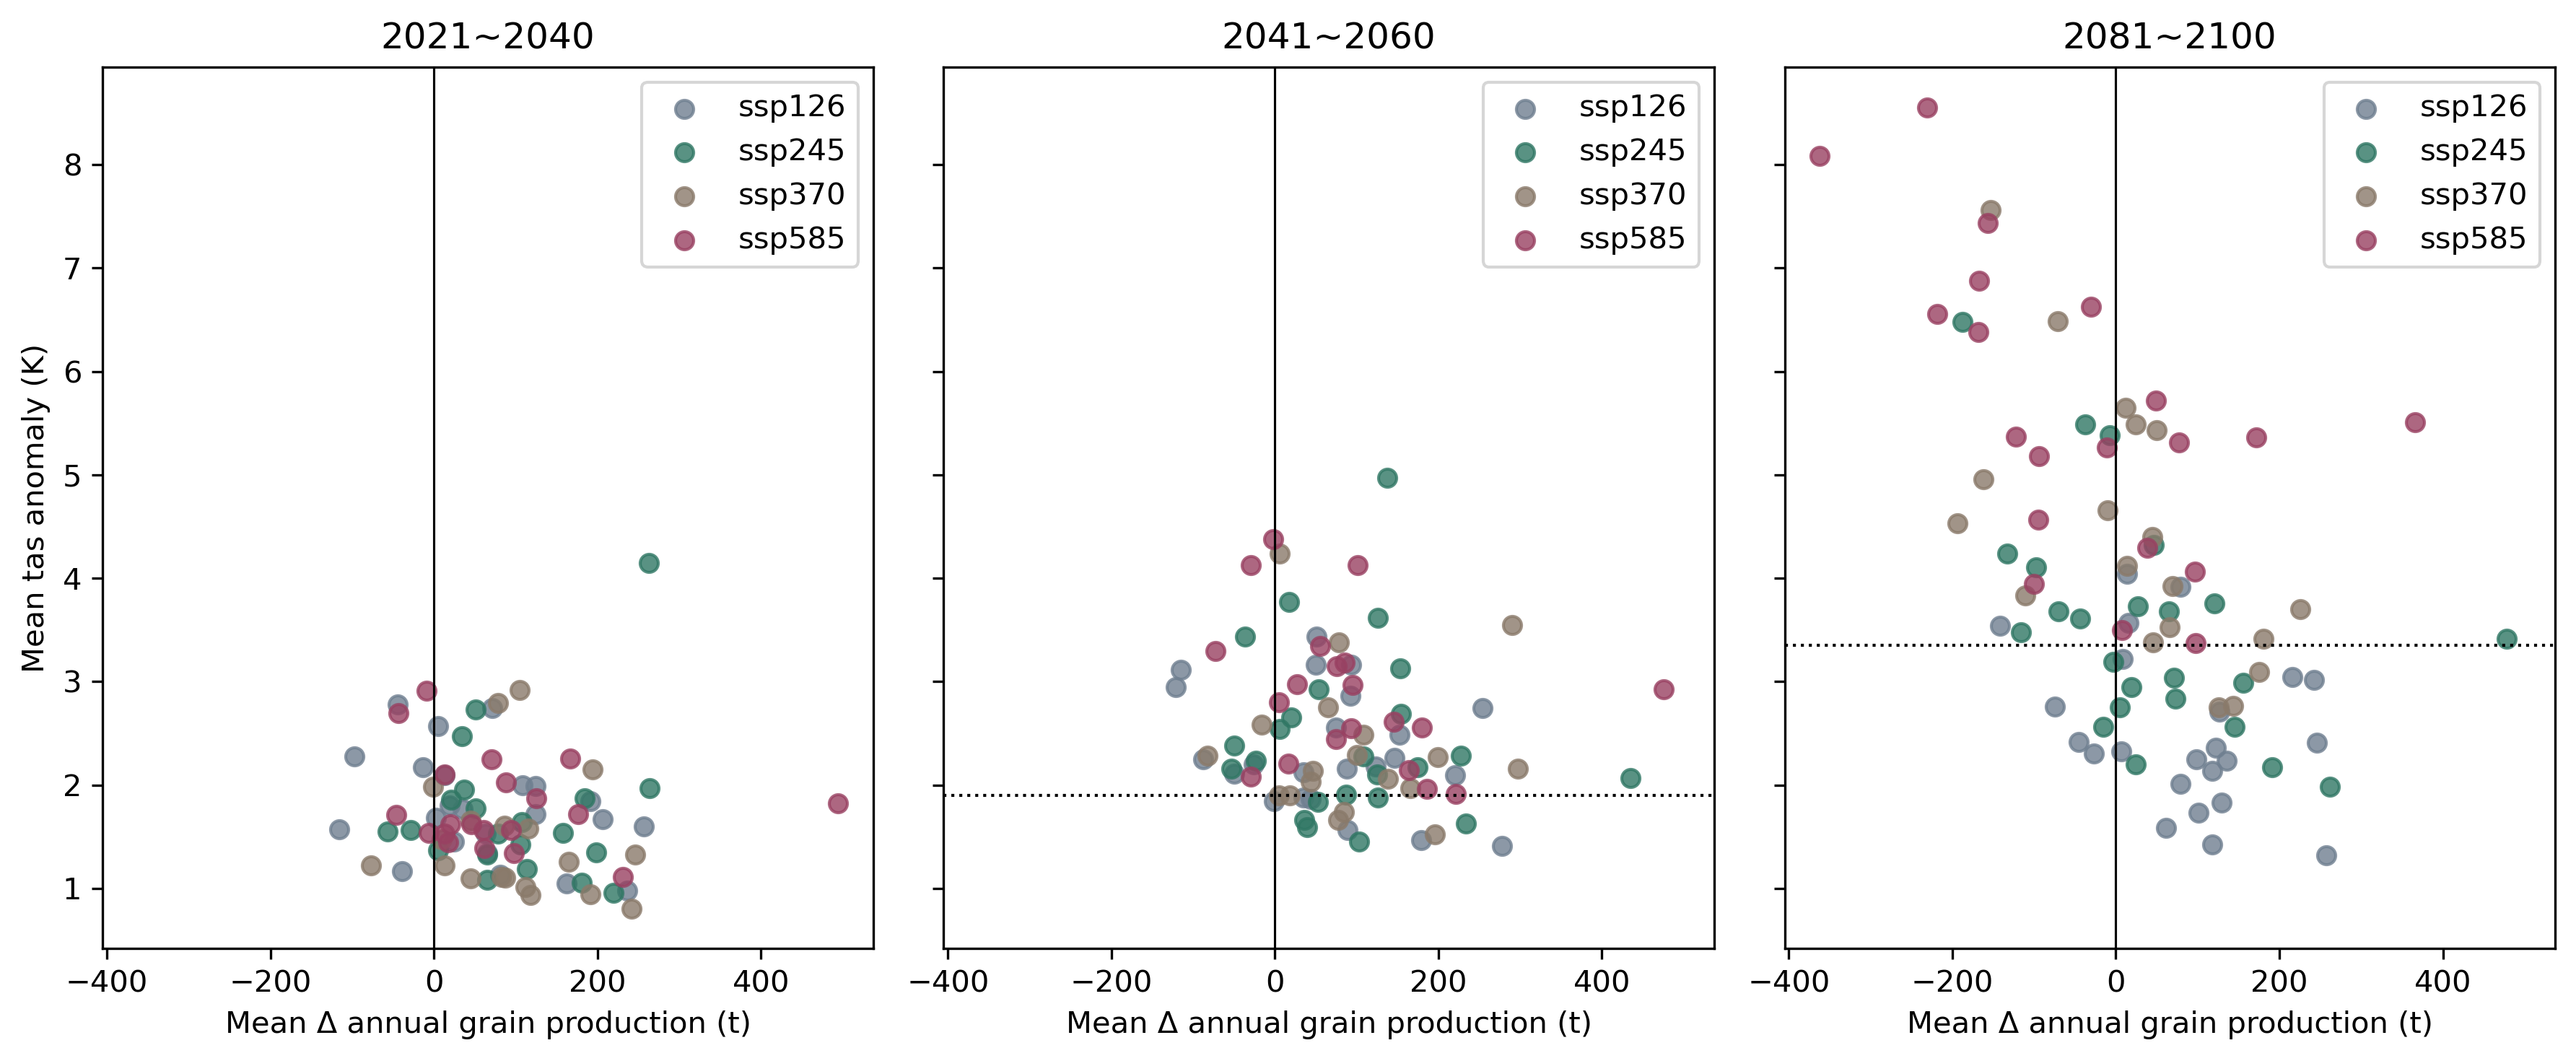

In [25]:
# Set up the plot
fig, axes=plt.subplots(1, 3, figsize=(12, 5), sharex=True,sharey=True, dpi=300)

ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
cli = ['#6f7f90', '#307764', '#8a7a6a', '#994162']

# Iterate over each SSP
for i in range(4):
    axes[0].scatter(y0[ssps[i]], X0[ssps[i]], label=ssps[i], color=cli[i], alpha=0.8)
    axes[1].scatter(y1[ssps[i]], X1[ssps[i]], label=ssps[i], color=cli[i], alpha=0.8)
    axes[2].scatter(y2[ssps[i]], X2[ssps[i]], label=ssps[i], color=cli[i], alpha=0.8)

# Adding labels and title
axes[0].set_xlabel('Mean Δ annual grain production (t)')
axes[1].set_xlabel('Mean Δ annual grain production (t)')
axes[2].set_xlabel('Mean Δ annual grain production (t)')
axes[0].set_ylabel('Mean tas anomaly (K)')

axes[0].set_title('2021~2040')
axes[0].legend()

axes[1].set_title('2041~2060')
axes[1].legend()

axes[2].set_title('2081~2100')
axes[2].legend()

axes[0].axvline(0, linewidth=0.75, c='black')
axes[1].axvline(0, linewidth=0.75, c='black')
axes[2].axvline(0, linewidth=0.75, c='black')

#axes[0].axhline(2, linewidth=1, c='black', linestyle=':')
axes[1].axhline(1.9, linewidth=1, c='black', linestyle=':')
axes[2].axhline(3.35, linewidth=1, c='black', linestyle=':')

#axes[0].set_ylim(-5, 9)

# Show the plot
fig.tight_layout()
plt.show()